In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(4919, 20)
(4919, 3)


In [6]:
X_motion_CoM[0, :]

array([0.0, 0.0, 0.0, 0.2367076873779297, 0.13032740354537964,
       -0.38392701745033264, 0.23329761624336243, -0.12881384789943695,
       -0.38883692026138306, -0.26291489601135254, 0.12768769264221191,
       -0.3896667957305908, -0.2635267972946167, -0.11768043041229248,
       -0.38761088252067566, 0.0, 0.0, 0.0, False, True], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, -2] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(2452,)

In [15]:
X_motion_CoM_FL_RR[0, :]

array([0.0, 0.0, 0.0, 0.2432394176721573, 0.12949177622795105,
       -0.3750806748867035, 0.23362915217876434, -0.12918084859848022,
       -0.37532877922058105, -0.2643287181854248, 0.13117615878582,
       -0.37639665603637695, -0.2555374503135681, -0.11666833609342575,
       -0.37763866782188416, 0.0, 0.0, 0.0, True, False], dtype=object)

In [16]:
Y_motion_CoM_FL_RR[0, :]

array([-0.010377705545657534, -0.006732190228054158, 0.003912049484119232],
      dtype=object)

## Predict CoM -> x

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.09977452202715298
RMSE:  0.06193637775286906
The lowest error is:  0.0001387688559808531
The highest error is:  0.6817446675106695
The avg. error is:  0.0251846318761981


In [11]:
model_fl_com_x.coef_

array([[ 1.69727962e-01,  6.45317133e-16,  4.44089210e-16,
        -6.76932669e-02,  4.44089210e-16,  6.66133815e-16,
         2.96615670e+00,  1.89107990e+00,  1.03806370e-01,
         2.03663128e-01,  1.01702227e+00, -1.02204858e+00,
        -2.60006755e+00, -2.09298988e+00]])

In [12]:
model_fl_com_x.intercept_

array([-1.46001146])

In [13]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[0.0190959]])

Text(0, 0.5, 'Predictions')

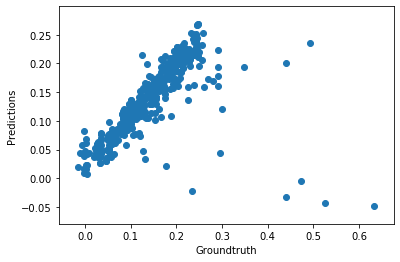

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [15]:
#%store model_fl_com_x

In [16]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [17]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [18]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.923895384204574
RMSE:  0.0019704133953424617
The lowest error is:  1.7067990264255095e-06
The highest error is:  0.0072849625377077384
The avg. error is:  0.0014567301632331879


In [19]:
model_fl_com_y.coef_

array([[ 2.01061822e-03, -1.59594560e-16, -5.55111512e-17,
        -2.84083652e-02,  4.00721123e-16,  4.16333634e-17,
         3.32538690e-02, -2.22784381e-02, -2.83648172e-01,
         1.73305070e-01,  3.09533288e-01,  3.58611466e-01,
        -5.30169914e-02, -4.81369075e-01]])

In [20]:
model_fl_com_y.intercept_

array([0.04840229])

Text(0, 0.5, 'Predictions')

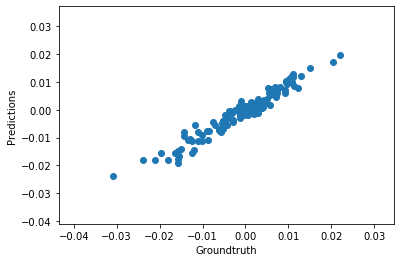

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [22]:
#%store model_fl_com_y

In [23]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [24]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [25]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -0.46486451039285126
RMSE:  0.0008093593276357267
The lowest error is:  1.5175513041580657e-06
The highest error is:  0.002275494252268251
The avg. error is:  0.0006380797657469175


In [26]:
model_fl_com_theta.coef_

array([[-1.34623669e-03,  6.93889390e-17,  2.08166817e-17,
        -3.22547567e-03, -1.73472348e-16,  2.77555756e-17,
        -4.10206047e-02, -7.35003910e-03,  1.27384461e-01,
         6.50635021e-02, -1.16517707e-01, -7.54674972e-02,
         2.92143317e-02,  3.90481477e-02]])

In [27]:
model_fl_com_theta.intercept_

array([-0.02347458])

Text(0, 0.5, 'Predictions')

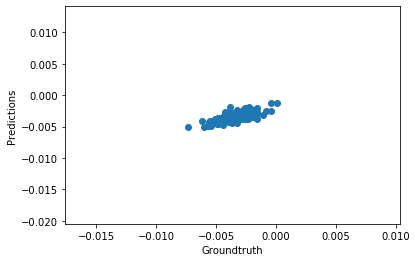

In [28]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")